In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import os


In [3]:
from src.p7_file import files_list_pattern, make_dir
from src.p7_file import download_file
from src.p7_file import dezip
from src.p7_file import display_head



from src.p7_constantes import DATA_URL, FILE_ZIP
from src.p7_constantes import DATA_DIR, DATA_BASE, DATA_CLEAN_DIR
from src.p7_constantes import MODEL_DIR
from src.p7_constantes import STYLE, PALETTE_LOW

from src.p7_missing_values import missing_values_barh


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

Constantes

In [ ]:
"""# CONSTANTES

# URL de téléchargement des données
DATA_URL = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip"
# Lien Kaggle sur les données
https://www.kaggle.com/c/home-credit-default-risk/data

"""

'# CONSTANTES\n\n# URL de téléchargement des données\nDATA_URL = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip"\n# Lien Kaggle sur les données\nhttps://www.kaggle.com/c/home-credit-default-risk/data\n\n'

Options d'affichage

In [4]:
# Options d'affichage notebook
pd.set_option('display.precision', 4)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_info_columns', 165) # .info() en détail
pd.set_option('display.max_colwidth', 600) # Chaînes longues
pd.set_option('display.max_rows', 80) # plus de lignes dans .head(), .tail(), si utile

Styles graphiques

In [5]:
#STYLE_PLOT = 'seaborn-v0_8-whitegrid'
sns.set_theme(context='notebook',
                style=STYLE,
                palette=PALETTE_LOW,
                font='sans-serif',
                font_scale=1,
                color_codes=True,
                rc=None)

In [6]:
plt.rcParams["figure.figsize"] = (10, 5)

# Téléchargement des données

Création de directories si nécessaire

In [7]:
# Si les répertoires pour stocker les données n'existent pas, on les crée
dir_to_create = [DATA_DIR, DATA_BASE, DATA_CLEAN_DIR, MODEL_DIR]
make_dir(dir_to_create)


Répertoire data/ créé
Répertoire data/base/ créé
Répertoire data/interim/ créé
Répertoire data/cleaned/ créé
Répertoire models/ créé


Téléchargement des données

In [8]:
# Télécharge le fichier archive du premier jeu de données
download_file(url_download=DATA_URL, dir_output=DATA_BASE, to_download=FILE_ZIP)

Projet+Mise+en+prod+-+home-credit-default-risk.zip téléchargé dans le répertoire data/base/
Archive zip dézippée dans le répertoire data/base/


dézip

In [9]:
# On dézipe l'archive contenant les données
dezip(DATA_BASE, FILE_ZIP)


Archive zip dézippée dans le répertoire data/base/


In [11]:
pattern = f"{DATA_BASE}*.csv"
files = files_list_pattern(pattern)
print(f"{len(files)}  fichier dézippés :")
for file in files:
    print(f"{file}")


10  fichier dézippés :
data/base\application_test.csv
data/base\application_train.csv
data/base\bureau.csv
data/base\bureau_balance.csv
data/base\credit_card_balance.csv
data/base\HomeCredit_columns_description.csv
data/base\installments_payments.csv
data/base\POS_CASH_balance.csv
data/base\previous_application.csv
data/base\sample_submission.csv


# liens intéressants

In [ ]:
# Notebook pour les débutants sur le concours : https://www.kaggle.com/code/seifmechi/credit-default-risk

# Economie RAM

In [ ]:
"""
Les datasets sont gros. On économise la RAM en réduisant les types. Exemple beaucoup de flags (0 ou 1) codés en int32, c'est inutile, on va les réduire en int8 etc.
"""

In [8]:
#Code repris de https://www.kaggle.com/code/seifmechi/credit-default-risk
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True)
    df = reduce_mem_usage(df)
    return df

# Exploration application_train

In [ ]:
"""
Tableau principal (avec la target pour le train)
Données statiques pour toutes les applications. Une ligne représente un prêt
"""

In [28]:
df = pd.read_csv(DATA_BASE + "application_train.csv", parse_dates=True, na_values=['XNA', 'Unknown'])
df.shape

(307511, 122)

In [29]:
test = pd.read_csv(DATA_BASE + "application_test.csv", parse_dates=True, na_values=['XNA', 'Unknown'])

In [27]:
# ratio test train
test.shape[0] / df.shape[0]
# Le test représente environ 15% du train. On va redécouper le train, on va prendre 20%

0.1585114028441259

In [30]:
cat_df = df.select_dtypes("object")
cat_df.head(0)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE


In [31]:
for feature in cat_df.columns:
    display(cat_df[feature].value_counts(dropna=False))

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

CODE_GENDER
F      202448
M      105059
NaN         4
Name: count, dtype: int64

FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: count, dtype: int64

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
NaN                          2
Name: count, dtype: int64

NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

OCCUPATION_TYPE
NaN                      96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

WEEKDAY_APPR_PROCESS_START
TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: count, dtype: int64

ORGANIZATION_TYPE
Business Entity Type 3    67992
NaN                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

FONDKAPREMONT_MODE
NaN                      210295
reg oper account          73830
reg oper spec account     12080
not specified              5687
org spec account           5619
Name: count, dtype: int64

HOUSETYPE_MODE
NaN                 154297
block of flats      150503
specific housing      1499
terraced house        1212
Name: count, dtype: int64

WALLSMATERIAL_MODE
NaN             156341
Panel            66040
Stone, brick     64815
Block             9253
Wooden            5362
Mixed             2296
Monolithic        1779
Others            1625
Name: count, dtype: int64

EMERGENCYSTATE_MODE
No     159428
NaN    145755
Yes      2328
Name: count, dtype: int64

In [16]:
df[df["CODE_GENDER"] == "XNA"]['TARGET']

35657     0
38566     0
83382     0
189640    0
Name: TARGET, dtype: int64

In [23]:
# 80 ans de travail
max_days_employed = 80 * 365
df.loc[df['DAYS_EMPLOYED'] > max_days_employed, ['DAYS_EMPLOYED']].value_counts()

DAYS_EMPLOYED
365243           55374
Name: count, dtype: int64

Anciennement début

In [7]:
df = import_data(DATA_BASE + "application_train.csv")
df.info()

NameError: name 'import_data' is not defined

Doublons sur la clef

In [10]:
# On vérifie qu'il n'y a aucun doublon sur la clef
duplicated_id = df[df['SK_ID_CURR'].duplicated()==True]
print("\nNombre de doublons sur la clef ('SK_ID_CURR') :", duplicated_id.shape[0])
print (f"le fichier application_train contient {df['SK_ID_CURR'].nunique()} prêts distincts")


Nombre de doublons sur la clef ('SK_ID_CURR') : 0
le fichier application_train contient 307511 prêts distincts


## Valeurs manquantes

Valeurs manquantes

<Axes: >

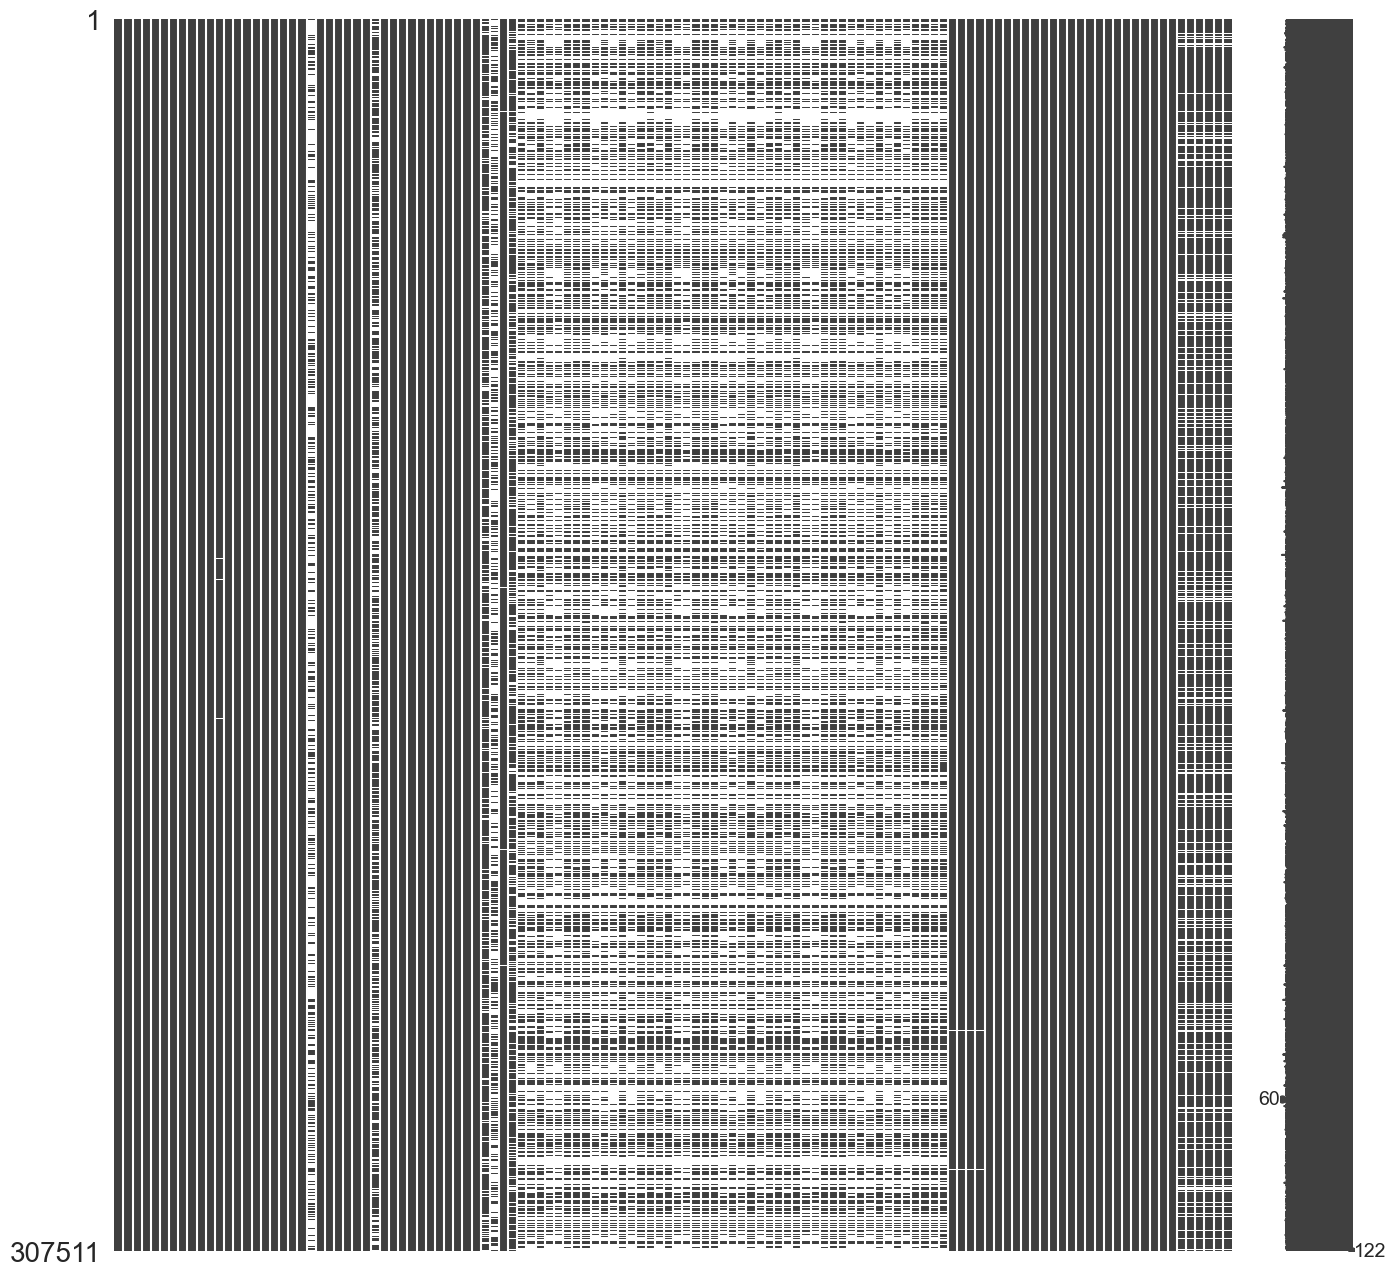

In [32]:
msno.matrix(df, figsize=(16,16))

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:607: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if missing_values[i] <= limit_bottom:  # groupe du bas
e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:613: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif np.round(missing_values[i], decimals) >= limit_top:


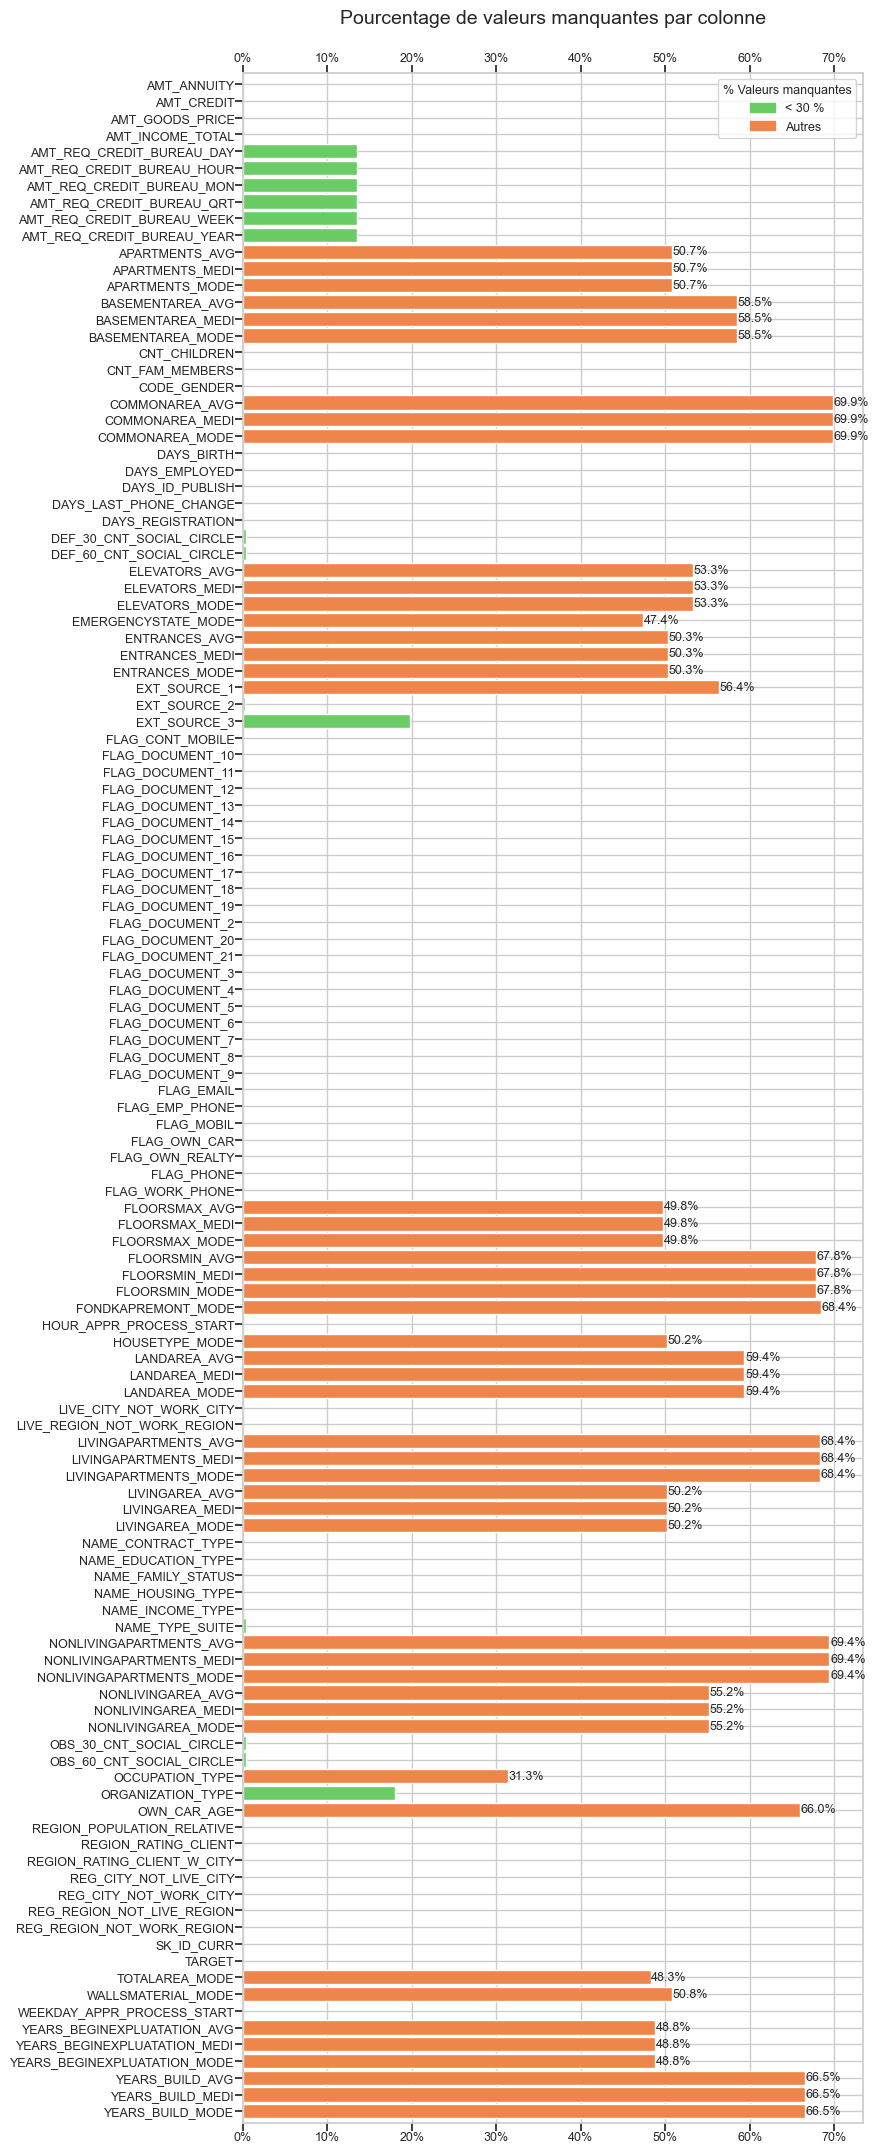

In [33]:
missing_columns, _, _ = missing_values_barh(df, sort="index")

In [12]:
plt.close("all")

In [ ]:
# features retenues dans la solution lightGBM

usefull_features = [
        "CODE_GENDER",
        "FLAG_OWN_CAR",
        "NAME_CONTRACT_TYPE",
        "NAME_EDUCATION_TYPE",
        "NAME_FAMILY_STATUS",
        "NAME_HOUSING_TYPE",
        "NAME_INCOME_TYPE",
        "OCCUPATION_TYPE",
        "ORGANIZATION_TYPE",
        "WEEKDAY_APPR_PROCESS_START",
        "NAME_TYPE_SUITE",
        "WALLSMATERIAL_MODE",
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'DAYS_BIRTH',
        'DAYS_EMPLOYED',
        'EXT_SOURCE_1', 
        'EXT_SOURCE_2',
        'EXT_SOURCE_3',
    ]
# Features droppées dans la solution lightGBM
dropped_features = []

## Target

In [113]:
def plot_target(series):
    labels = ["Ok", "Défaut"]
    # Plot en camembert
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.suptitle(f"TARGET : Pourcentage de prêts avec et sans défaut de remboursement")
    ax.pie(
        series.value_counts(normalize=True),
        labels=labels,
        autopct='%.1f%%',
        )
        
    fig.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return


In [ ]:

plot_target(df['TARGET'])

In [60]:
"""
Gros déséquilibre de classe dans la Target
"""

''

# Avec get_application

In [34]:
from src.p7_simple_kernel import application

In [35]:
df = application()

Data samples: 307511


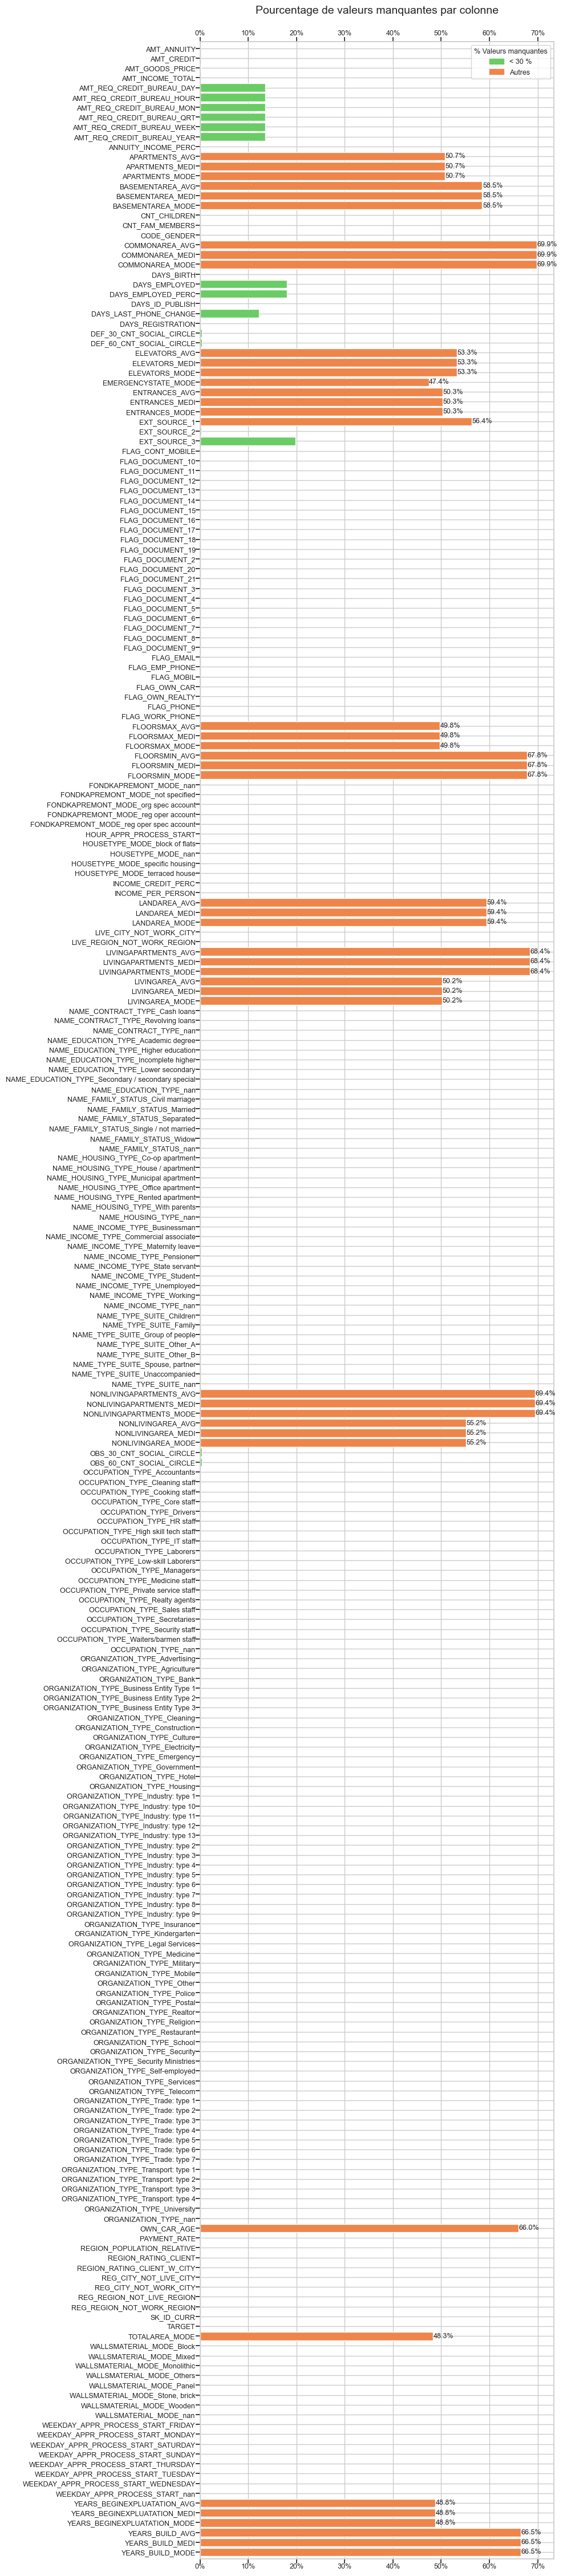

In [36]:
missing_columns, _, _ = missing_values_barh(df, sort="index")

In [38]:
np.unique(df['DAYS_ID_PUBLISH'])

array([-7197, -6551, -6383, ...,    -2,    -1,     0], dtype=int64)

In [39]:
df[df['DAYS_ID_PUBLISH'] == 0].shape

(16, 256)

## Suppression par % de valeurs manquantes

### pass 1

Suppression de colonnes -  - Valeurs manquantes par colonnes pour les non defaut

In [13]:
df_no_default = df[df['TARGET'] == 0]
df_no_default.shape

(282686, 122)

In [32]:
from src.p7_missing_values import mv_loss_ceils_lines, mv_loss_ceils_graph, mv_loss_ceils_columns

In [37]:
ceils, loss_by_ceil = mv_loss_ceils_columns(df_no_default, start=30, stop=72, step=1)

In [38]:
ceils

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71])

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': "Elimination de COLONNES\nPerte d'information par seuil de valeurs manquantes toléré"}, xlabel="Seuil d'élimination de colonnes (en % de valeurs manquantes par colonne)", ylabel='% de valeurs renseignées\ndans les colonnes à éliminer'>)

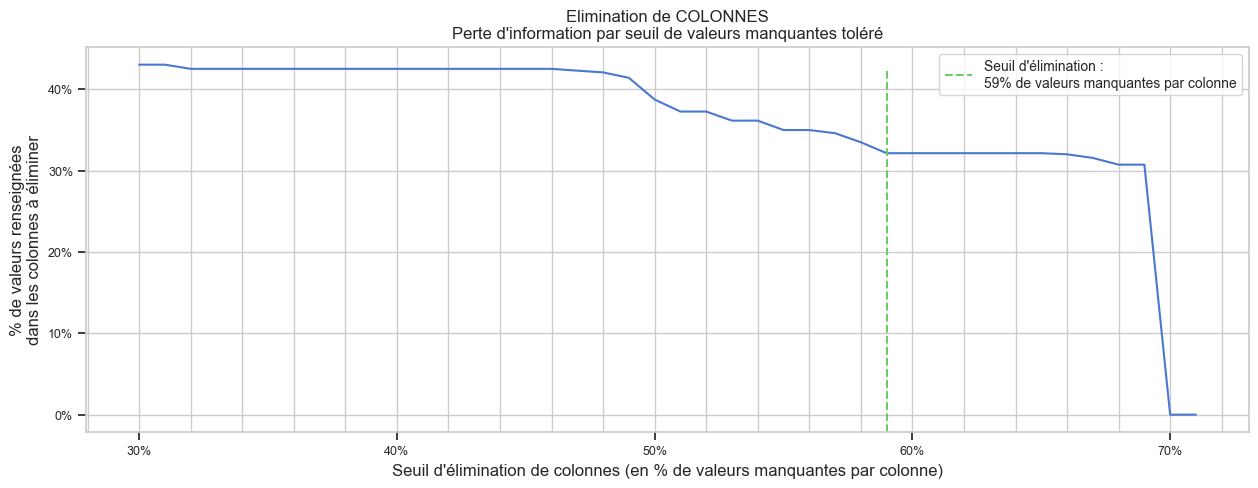

In [40]:
mv_loss_ceils_graph(x=ceils, y=loss_by_ceil, type_to_eliminate='columns', ceil=59)

In [42]:
# On supprime les colonnes à plus de 59% de valeurs manquantes
col_to_drop = missing_columns[missing_columns > 59]
col_to_drop

YEARS_BUILD_MODE            66.4978
YEARS_BUILD_MEDI            66.4978
YEARS_BUILD_AVG             66.4978
OWN_CAR_AGE                 65.9908
NONLIVINGAPARTMENTS_MODE    69.4330
NONLIVINGAPARTMENTS_MEDI    69.4330
NONLIVINGAPARTMENTS_AVG     69.4330
LIVINGAPARTMENTS_MODE       68.3550
LIVINGAPARTMENTS_MEDI       68.3550
LIVINGAPARTMENTS_AVG        68.3550
LANDAREA_MODE               59.3767
LANDAREA_MEDI               59.3767
LANDAREA_AVG                59.3767
FONDKAPREMONT_MODE          68.3862
FLOORSMIN_MODE              67.8486
FLOORSMIN_MEDI              67.8486
FLOORSMIN_AVG               67.8486
COMMONAREA_MODE             69.8723
COMMONAREA_MEDI             69.8723
COMMONAREA_AVG              69.8723
dtype: float64

In [45]:
df = df.drop(col_to_drop.index, axis=1)
df.shape

(307511, 102)

In [ ]:
df_no_default = df[df['TARGET'] == 0]
df_no_default.shape

(282686, 122)

Suppression de lignes - Valeurs manquantes par lignes pour les non defaut

In [46]:
df_no_default = df[df['TARGET'] == 0]
df_no_default.shape

(282686, 102)

In [72]:
ceils, loss_filled_values, loss_lines, missing_values_by_line = mv_loss_ceils_lines(df_no_default, start=10, stop=45, step=1)

In [54]:
ceils

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44])

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': "Elimination de LIGNES\nPerte d'information par seuil de valeurs manquantes toléré"}, xlabel="Seuil d'élimination de lignes (en % de valeurs manquantes par ligne)", ylabel='% de valeurs renseignées\ndans les lignes à éliminer'>)

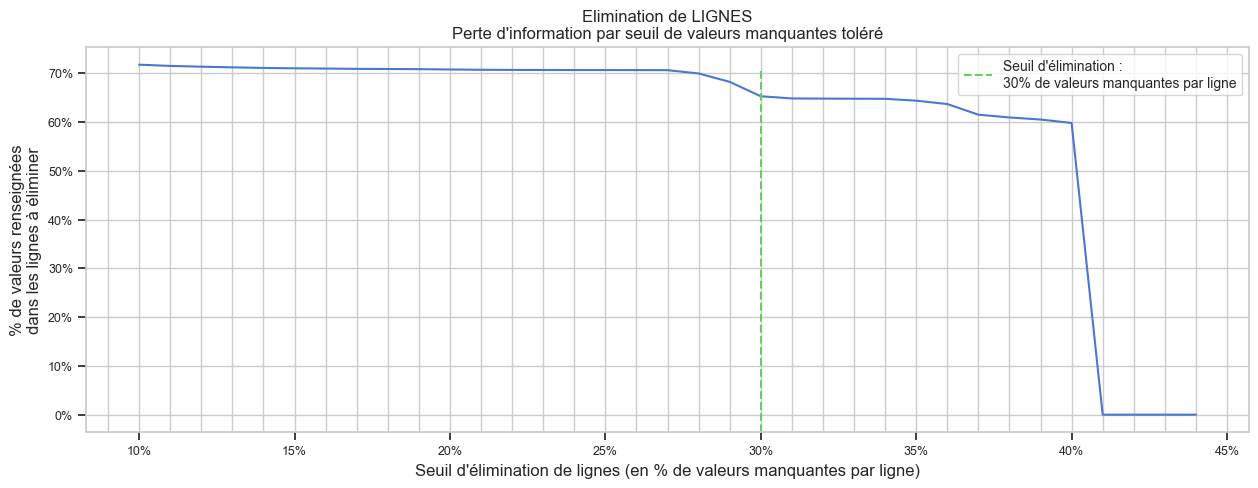

In [78]:
ceil = 30
mv_loss_ceils_graph(x=ceils, y=loss_filled_values, type_to_eliminate='lines', ceil=ceil)

In [79]:
missing_values_by_line.sort_values(ascending=False)

197736    40.1961
269492    40.1961
69707     40.1961
53941     40.1961
244833    40.1961
           ...   
185287     0.0000
185318     0.0000
185322     0.0000
185337     0.0000
307510     0.0000
Length: 282686, dtype: float64

In [83]:
# On éliùmine toutes les lignes à plus du seuil de valeurs manquante
to_drop = missing_values_by_line[missing_values_by_line > ceil]
print("Nombre de lignes à éliminer", to_drop.shape[0])
df = df.drop(to_drop.index)
print("Nouvelle forme de Application_train", df.shape)

Nombre de lignes à éliminer (21390,)
Nouvelle forme de Application_train (286121, 102)


Nouvelles valeurs manquantes par colonne

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:607: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if missing_values[i] <= limit_bottom:  # groupe du bas
e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:613: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif np.round(missing_values[i], decimals) >= limit_top:


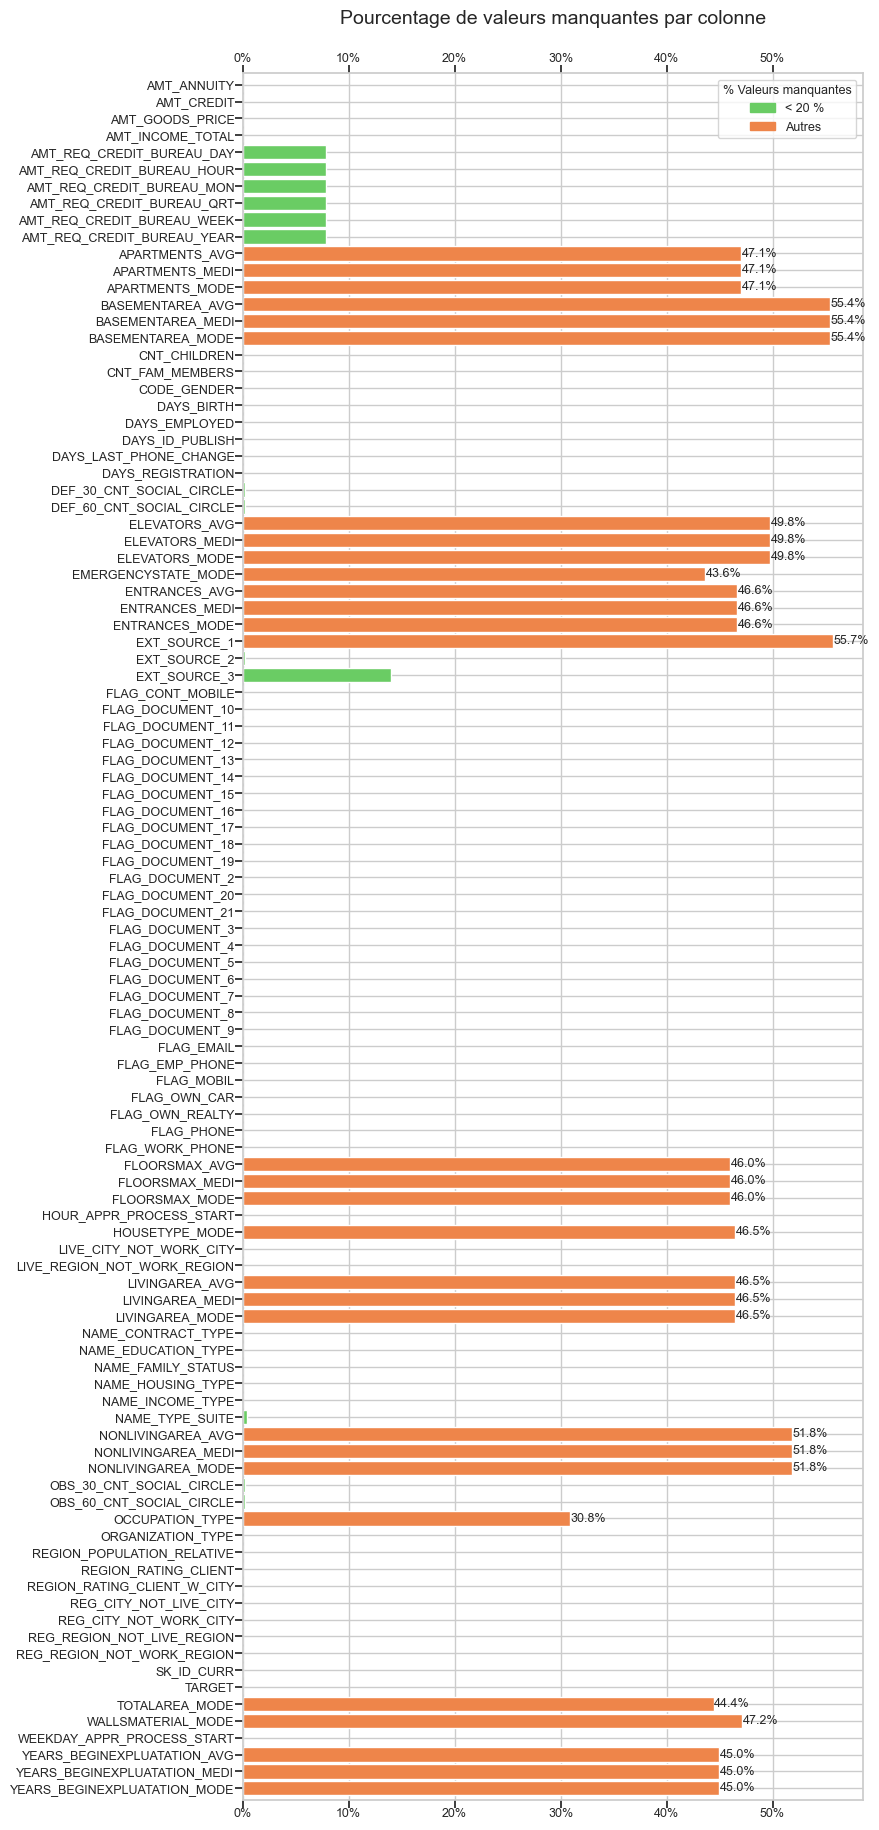

In [84]:
missing_columns, _, _ = missing_values_barh(df, sort="index")

### Pass 2

Suppression de colonnes

In [85]:
df_no_default = df[df['TARGET'] == 0]
df_no_default.shape

(261296, 102)

In [88]:
ceils, loss_by_ceil = mv_loss_ceils_columns(df_no_default, start=20, stop=58, step=1)

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': "Elimination de COLONNES\nPerte d'information par seuil de valeurs manquantes toléré"}, xlabel="Seuil d'élimination de colonnes (en % de valeurs manquantes par colonne)", ylabel='% de valeurs renseignées\ndans les colonnes à éliminer'>)

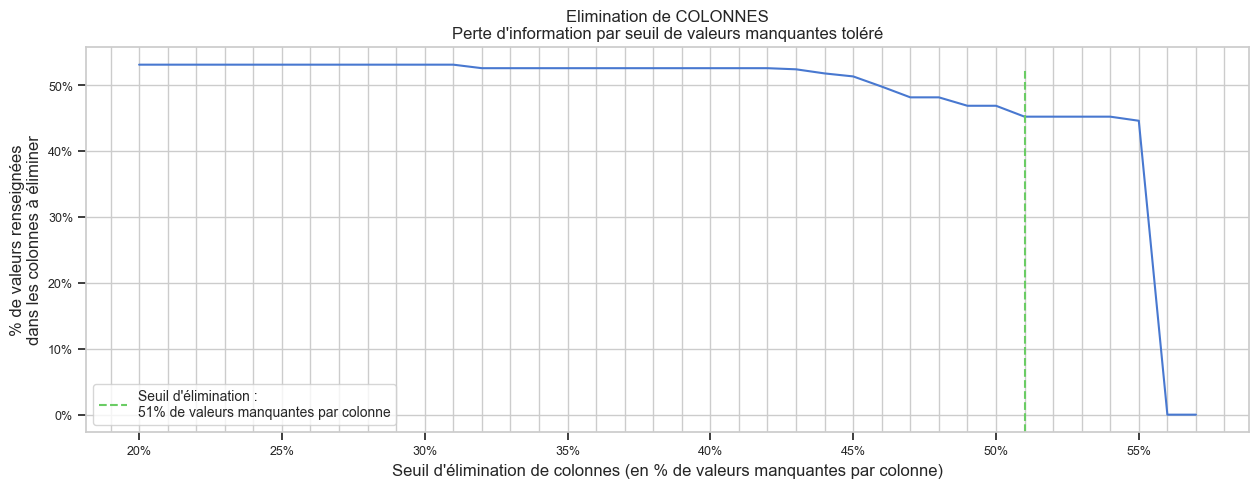

In [90]:
ceil = 51
mv_loss_ceils_graph(x=ceils, y=loss_by_ceil, type_to_eliminate='columns', ceil=ceil)

In [91]:
# On supprime les colonnes à plus de seuil de valeurs manquantes
col_to_drop = missing_columns[missing_columns > ceil]
col_to_drop

NONLIVINGAREA_MODE    51.8284
NONLIVINGAREA_MEDI    51.8284
NONLIVINGAREA_AVG     51.8284
EXT_SOURCE_1          55.7271
BASEMENTAREA_MODE     55.4147
BASEMENTAREA_MEDI     55.4147
BASEMENTAREA_AVG      55.4147
dtype: float64

In [92]:
df = df.drop(col_to_drop.index, axis=1)
df.shape

(286121, 95)

Suppression de lignes

In [93]:
df_no_default = df[df['TARGET'] == 0]
df_no_default.shape

(261296, 95)

In [100]:
ceils, loss_filled_values, loss_lines, missing_values_by_line = mv_loss_ceils_lines(df_no_default, start=0, stop=35, step=1)

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': "Elimination de LIGNES\nPerte d'information par seuil de valeurs manquantes toléré"}, xlabel="Seuil d'élimination de lignes (en % de valeurs manquantes par ligne)", ylabel='% de valeurs renseignées\ndans les lignes à éliminer'>)

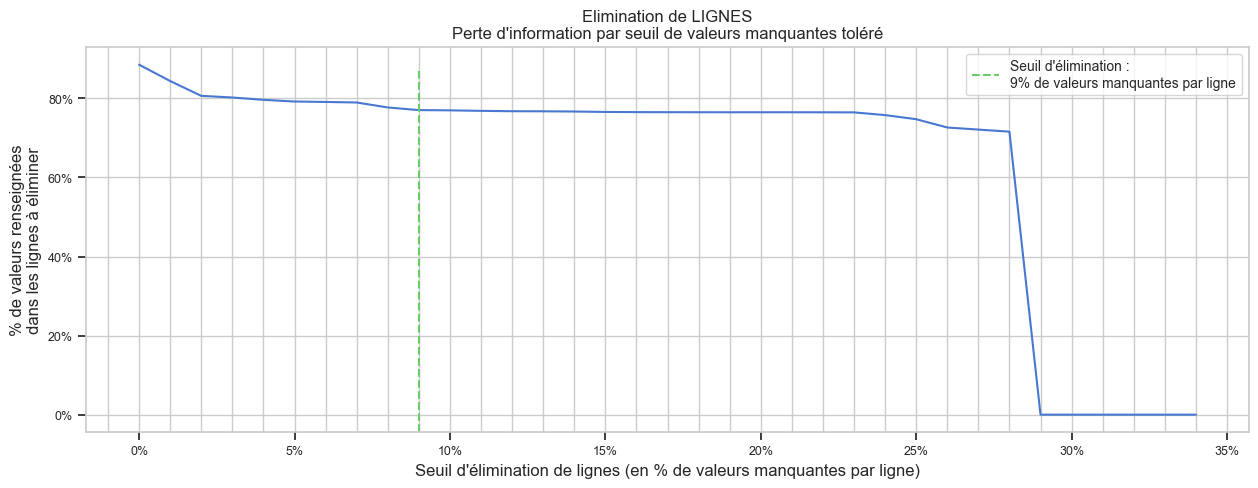

In [108]:
ceil = 9
mv_loss_ceils_graph(x=ceils, y=loss_filled_values, type_to_eliminate='lines', ceil=ceil)

In [109]:
missing_values_by_line.sort_values(ascending=False)

189265    28.4211
120857    27.3684
233257    26.3158
79256     25.2632
125814    25.2632
           ...   
250210     0.0000
100980     0.0000
169771     0.0000
100975     0.0000
307510     0.0000
Length: 261296, dtype: float64

In [110]:
# On éliùmine toutes les lignes à plus du seuil de valeurs manquante
to_drop = missing_values_by_line[missing_values_by_line > ceil]
print("Nombre de lignes à éliminer", to_drop.shape[0])


Nombre de lignes à éliminer 120609


In [111]:
df = df.drop(to_drop.index)
print("Nouvelle forme de Application_train", df.shape)

Nouvelle forme de Application_train (165512, 95)


Nouvelles valeurs manquantes par colonne

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:607: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if missing_values[i] <= limit_bottom:  # groupe du bas
e:\Mes Documents\_Open Classroom\Code\p7\src\p7_missing_values.py:613: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif np.round(missing_values[i], decimals) >= limit_top:


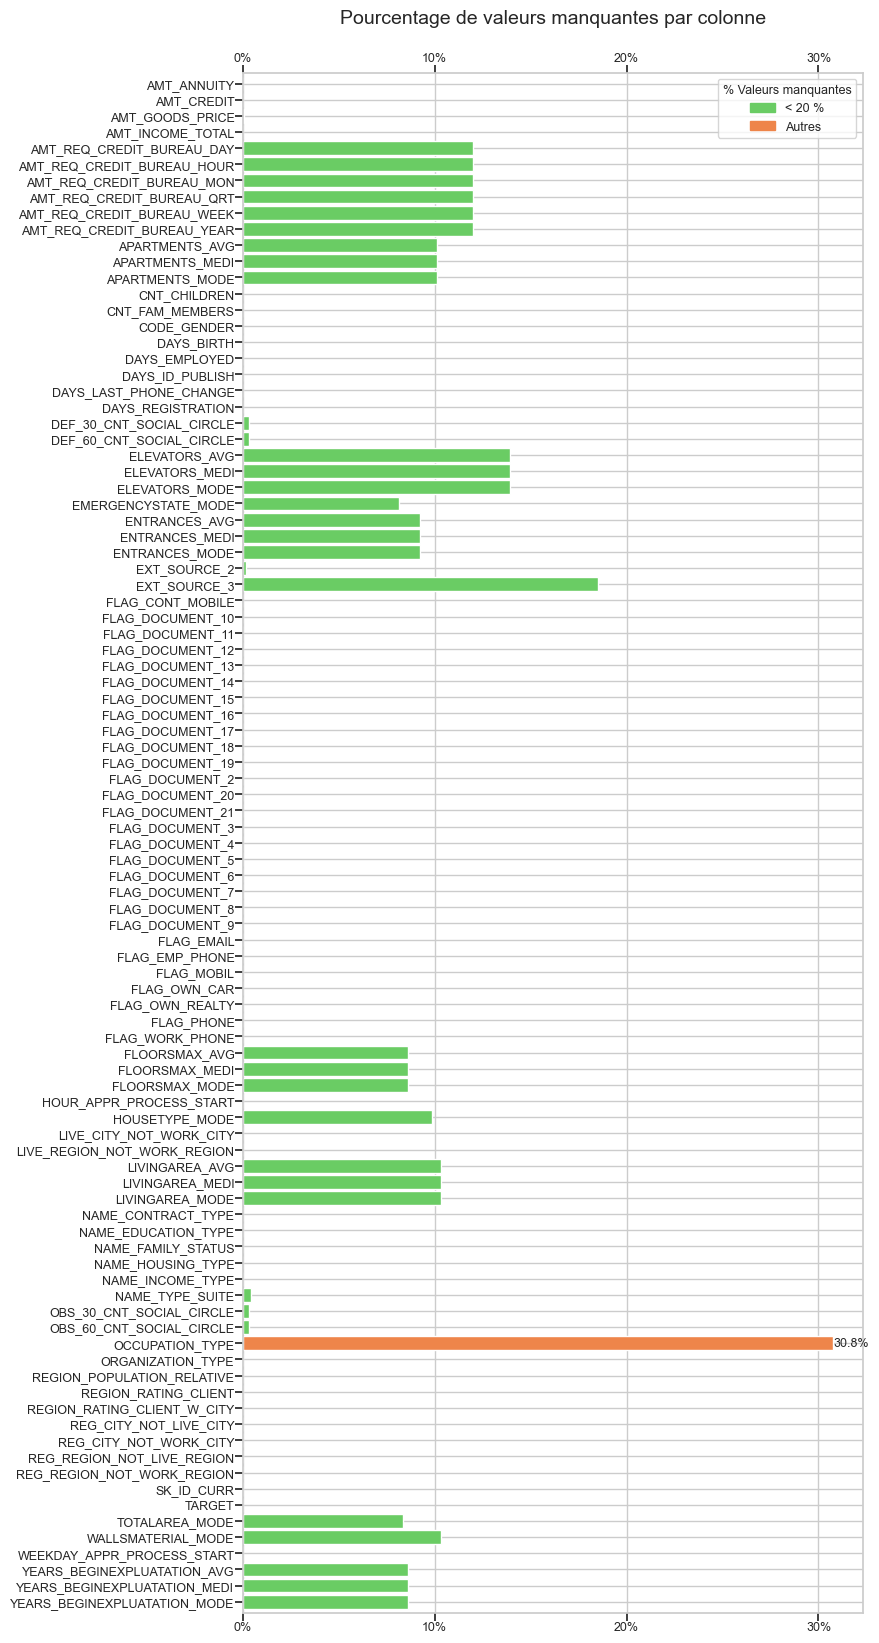

In [112]:
missing_columns, _, _ = missing_values_barh(df, sort="index")

### Nouvelle proportion target

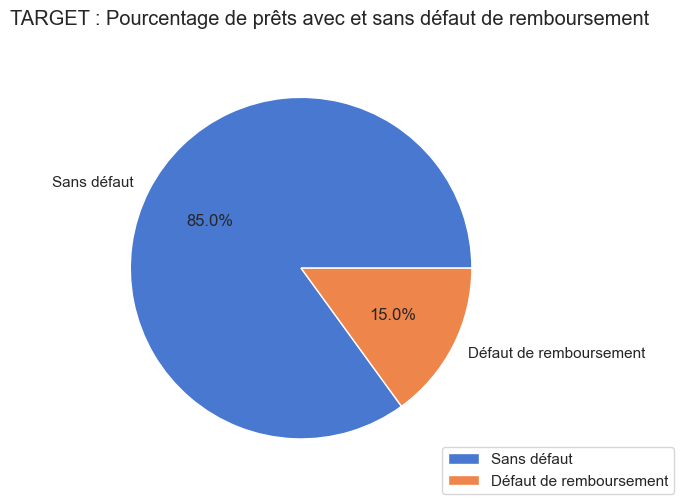

In [114]:
plot_target(df['TARGET'])

## Types de features

In [116]:
df.dtypes.value_counts()

int8       37
float16    35
object     15
float32     4
int32       2
int16       2
Name: count, dtype: int64

In [117]:
# Liste des features numériques
numeric_features = df.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns
numeric_features

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG',
       'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATIO

In [119]:
# Nombre de modalités des features non numériques
df.select_dtypes(exclude='number').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [122]:
for var in df.select_dtypes(exclude='number'):
    print(f"Nombre d'observations par modalités de {var} :")
    print(df[var].value_counts())
    print()

Nombre d'observations par modalités de NAME_CONTRACT_TYPE :
NAME_CONTRACT_TYPE
Cash loans         149125
Revolving loans     16387
Name: count, dtype: int64

Nombre d'observations par modalités de CODE_GENDER :
CODE_GENDER
F      109603
M       55906
XNA         3
Name: count, dtype: int64

Nombre d'observations par modalités de FLAG_OWN_CAR :
FLAG_OWN_CAR
N    111727
Y     53785
Name: count, dtype: int64

Nombre d'observations par modalités de FLAG_OWN_REALTY :
FLAG_OWN_REALTY
Y    116112
N     49400
Name: count, dtype: int64

Nombre d'observations par modalités de NAME_TYPE_SUITE :
NAME_TYPE_SUITE
Unaccompanied      135668
Family              20313
Spouse, partner      5544
Children             1669
Other_B               983
Other_A               494
Group of people       144
Name: count, dtype: int64

Nombre d'observations par modalités de NAME_INCOME_TYPE :
NAME_INCOME_TYPE
Working                 83664
Commercial associate    42552
Pensioner               28201
State servant      

In [ ]:
#Ya pas photo,il faut se les faire un par un  

Features numériques

In [62]:
numeric_features = df.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns
# Si nous laissons les types restreints, certaines valeurs ne pourront pas être calculées à cause d'un overflow.
# On réalise le describe sur les types non restreints
pd.read_csv(DATA_BASE + "application_train.csv").describe(include=np.number)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0000,307511.0000,307511.0000,3.0751e+05,3.0751e+05,307499.0000,3.0723e+05,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,104582.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307509.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,134133.0000,3.0685e+05,246546.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,159080.0000,306490.0000,306490.0000,306490.0000,306490.0000,307510.0000,3.0751e+05,307511.0000,3.0751e+05,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,3.0751e+05,307511.0000,3.0751e+05,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000
mean,278180.5186,0.0807,0.4171,1.6880e+05,5.9903e+05,27108.5739,5.3840e+05,0.0209,-16036.9951,63815.0459,-4986.1203,-2994.2024,12.0611,1.0000,0.8199,0.1994,0.9981,0.2811,0.0567,2.1527,2.0525,2.0315,12.0634,0.0151,0.0508,0.0407,0.0782,0.2305,0.1796,0.5021,5.1439e-01,0.5109,0.1174,0.0884,0.9777,0.7525,0.0446,0.0789,0.1497,0.2263,0.2319,0.0663,0.1008,0.1074,0.0088,0.0284,0.1142,0.0875,0.9771,0.7596,0.0426,0.0745,0.1452,0.2223,0.2281,0.0650,0.1056,0.1060,0.0081,0.0270,0.1178,0.0880,0.9778,0.7557,0.0446,0.0781,0.1492,0.2259,0.2316,0.0672,0.1020,0.1086,0.0087,0.0282,0.1025,1.4222,0.1434,1.4053,0.1000,-962.8588,4.2275e-05,0.7100,8.1298e-05,0.0151,0.0881,0.0002,0.0814,0.0039,2.2763e-05,0.0039,6.5038e-06,0.0035,0.0029,0.0012,0.0099,0.0003,0.0081,0.0006,0.0005,0.0003,0.0064,0.0070,0.0344,0.2674,0.2655,1.9000
std,102790.175

In [ ]:
"""
features FLAG_DOCUMENT_ (jusqu'à 21)
présence ou l'absence de documents spécifiques dans le dossier du demandeur. 
Chaque indicateur représente un type de document différent (par exemple, des documents d'identification, des justificatifs de revenus, etc.)

AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR
représentent le nombre de demandes de renseignements ou de requêtes adressées à l'agence d'évaluation du crédit
par le demandeur au cours d'intervalles de temps spécifiques. 
Chaque feature correspond à une unité de temps différente (heure, jour, semaine, mois, trimestre, année).
"""

In [ ]:
"""
Un montant élevé d'emprunt conduit-il à un défaut ?
L'énorme annuité à rembourser peut-elle être la cause principale des défauts ?
Le nombre d'enfants a-t-il un impact sur le défaut de paiement ?
Le nombre de jours d'emploi, l'âge du demandeur ont-ils un impact négatif sur le défaut de remboursement ?
Le prix élevé des biens pour lesquels le prêt est demandé est-il à l'origine du défaut de paiement ?
Le montant limité des revenus est-il le principal facteur de défaut ?
features :
DAYS_BIRTH, DAYS_EMPLOYED, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE
"""

In [84]:
def plot_distribution(df, features):
    i = 0
    t1 = df.loc[df['TARGET'] == 1] # Avec défaut de paiement
    t0 = df.loc[df['TARGET'] == 0] # Remboursement OK

    fig, ax = plt.subplots(4, 2, figsize=(16, 20))
    fig.suptitle("Courbes de densité pour les emprunts avec et sans défaut de remboursement\n")
    for feature in features:
        if feature != 'TARGET':
            i += 1
            plt.subplot(4, 2, i)
            # bw utilisé pour spécifier la largeur de la fenêtre de noyau dans l'estimation de densité par noyau (KDE). 
            # Cela affecte la lissage du KDE et donc la "forme" de la courbe de densité.
            if i == 1:
                sns.kdeplot(t1[feature], bw_method=0.5, color='red', label="Défaut (TARGET=1)")
                sns.kdeplot(t0[feature], bw_method=0.5, label="Sans défaut")
            else:
                sns.kdeplot(t1[feature], bw_method=0.5, color='red')
                sns.kdeplot(t0[feature], bw_method=0.5)
            plt.ylabel('Densité', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=0)  # Set the font size for x-axis labels
            plt.yticks(fontsize=12)  # Set the font size for y-axis labels
    fig.legend()
    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

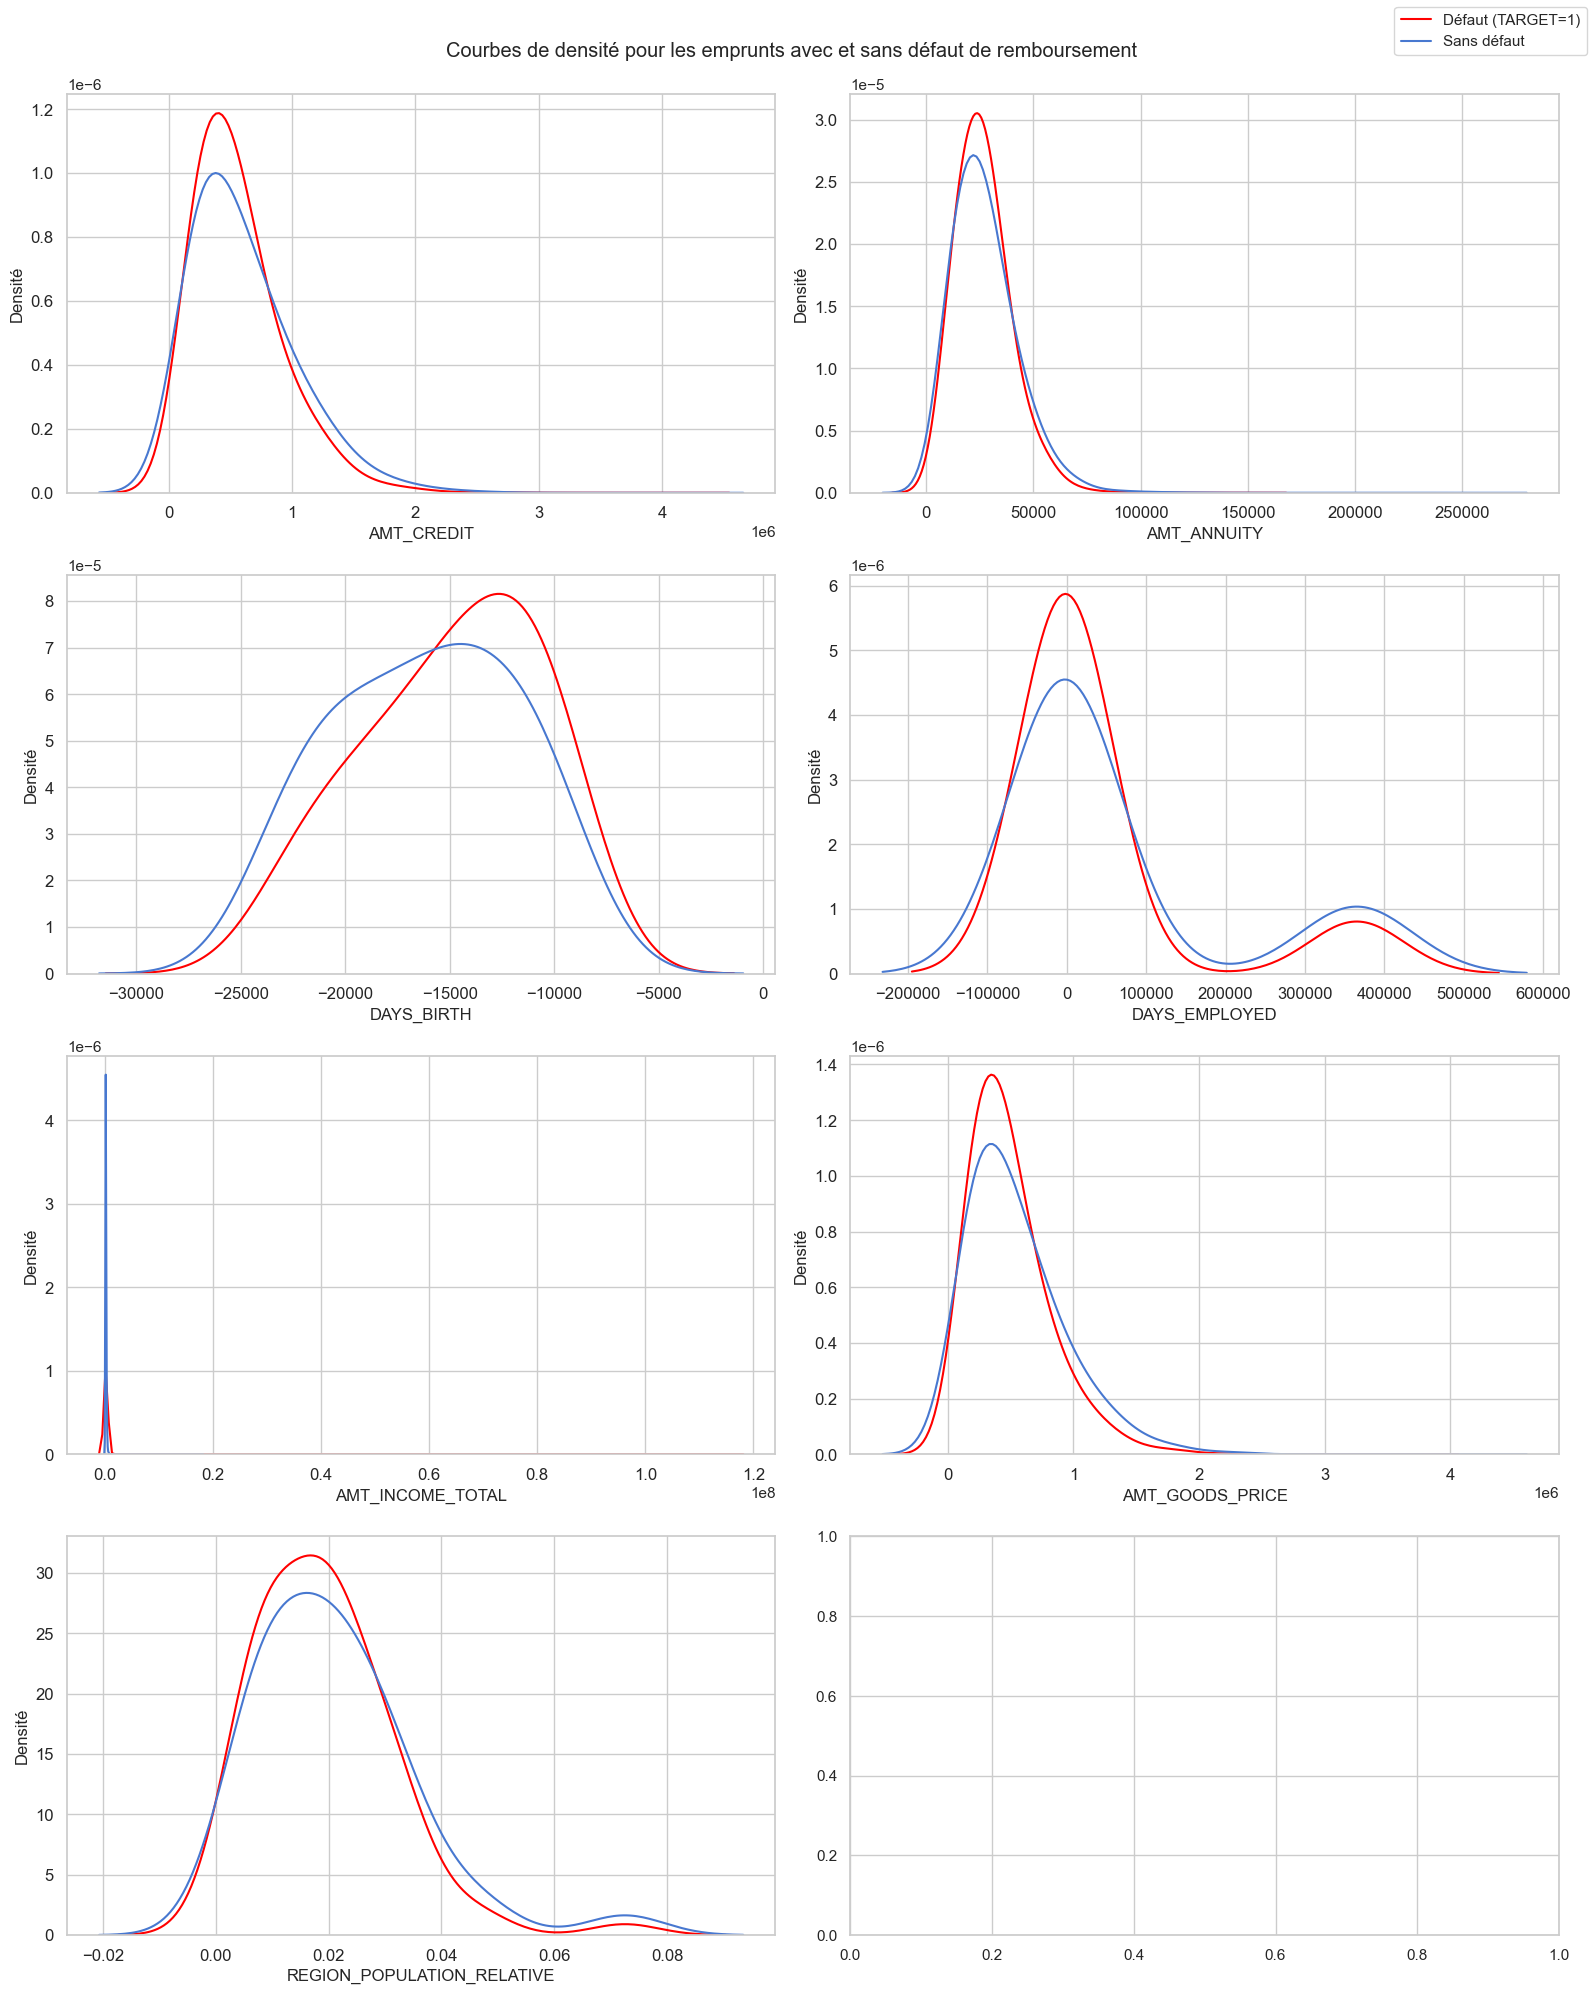

In [85]:
domain_features=['AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE']
plot_distribution(df, domain_features)

In [ ]:
"""
Graphique n° 1 : AMT_CREDIT
Le montant élevé du crédit n'est pas la cause de défaut. Cela s'explique par les procédures rigoureuses que les banques utilisent pour les prêts importants.
ce graphique montre également que la plupart des défaillants ont de petits crédits inférieurs à un million de dollars 
parce que les banques ne mettent pas en place des procédures compliquées pour contrôler les petits prêts comme pour les gros prêts.

Graphique n° 2 : AMT_ANNUITY
La similitude de la forme et de la moyenne de la distribution des annuités entre défaut==1 et défaut==0 suggère qu'en moyenne, 
les valeurs des annuités pour les deux groupes sont comparables. Cette similitude indique que les montants moyens des annuités ne sont pas significativement différents
entre les emprunteurs qui ont fait défaut et ceux qui n'ont pas fait défaut. 
Cependant, le graphique suggère qu'il pourrait y avoir une probabilité accrue de défaut pour les emprunteurs dont les valeurs d'annuités
se situent autour du sommet de la distribution (alors qu'ailleurs pas du tout).

Graphique n°3 : DAYS_BIRTH
Pour la troisième question La courbe target == 1 penche vers l'extrémité la plus jeune de la fourchette, 
les jeunes sont plus susceptibles d'être défaillants. 

Graphique n°4 : DAYS_EMPLOYED
La distribution de l'ancienneté indique que les nouveaux employés sont plus susceptibles de faire défaut.

Graphique n°5 : AMT_INCOME_TOTAL
Pour le revenu, On visualise mal car au moins une valeur très atypique gêne. 
Nous utiliserons une boîte à moustache pour l'interpréter.

"""

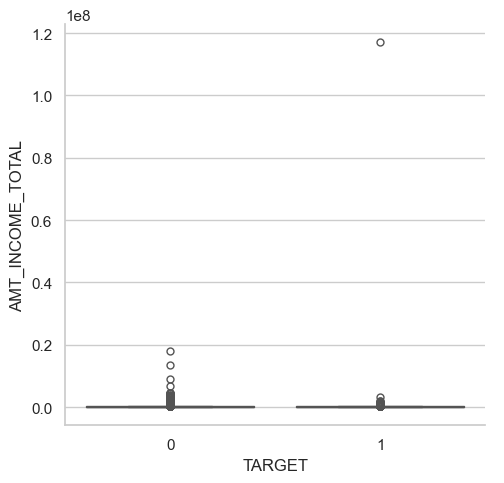

In [89]:
sns.catplot(df[['AMT_INCOME_TOTAL', 'TARGET']], x='TARGET', y='AMT_INCOME_TOTAL', kind='box')

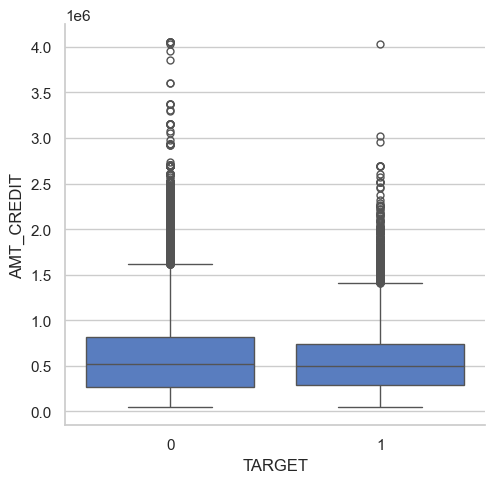

In [86]:
# En supprimant la valeur aberrante
sns.catplot(df.drop(df.AMT_INCOME_TOTAL.argmax()), x='TARGET', y='AMT_CREDIT', kind='box')

In [ ]:
"""
Pas de différence significative sur le revenu entre les défaillants et non défaillants
"""

In [91]:
'EXT_SOURCE_1' in df.columns
df['EXT_SOURCE_1']

0         0.0830
1         0.3113
2            NaN
3            NaN
4            NaN
           ...  
307506    0.1456
307507       NaN
307508    0.7441
307509       NaN
307510    0.7344
Name: EXT_SOURCE_1, Length: 307511, dtype: float16

# Exploration Bureau

In [ ]:
"""
Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés à Credit Bureau
(pour les clients qui ont un prêt dans l'échantillon)

Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans Credit Bureau avant la date de la demande.
"""

In [22]:
df_bureau = pd.read_csv(DATA_BASE + "bureau.csv")
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


Doublons sur la clef

In [25]:
# On vérifie qu'il n'y a aucun doublon sur la clef
duplicated_id = df[df['SK_ID_BUREAU'].duplicated()==True]
print("\nNombre de doublons sur la clef ('SK_ID_BUREAU') :", duplicated_id.shape[0])
print (f"le fichier bureau contient {df['SK_ID_BUREAU'].nunique()} anciens prêts distincts")


Nombre de doublons sur la clef ('SK_ID_BUREAU') : 44019
le fichier bureau contient 1465325 anciens prêts distincts


Valeurs manquantes

<Axes: >

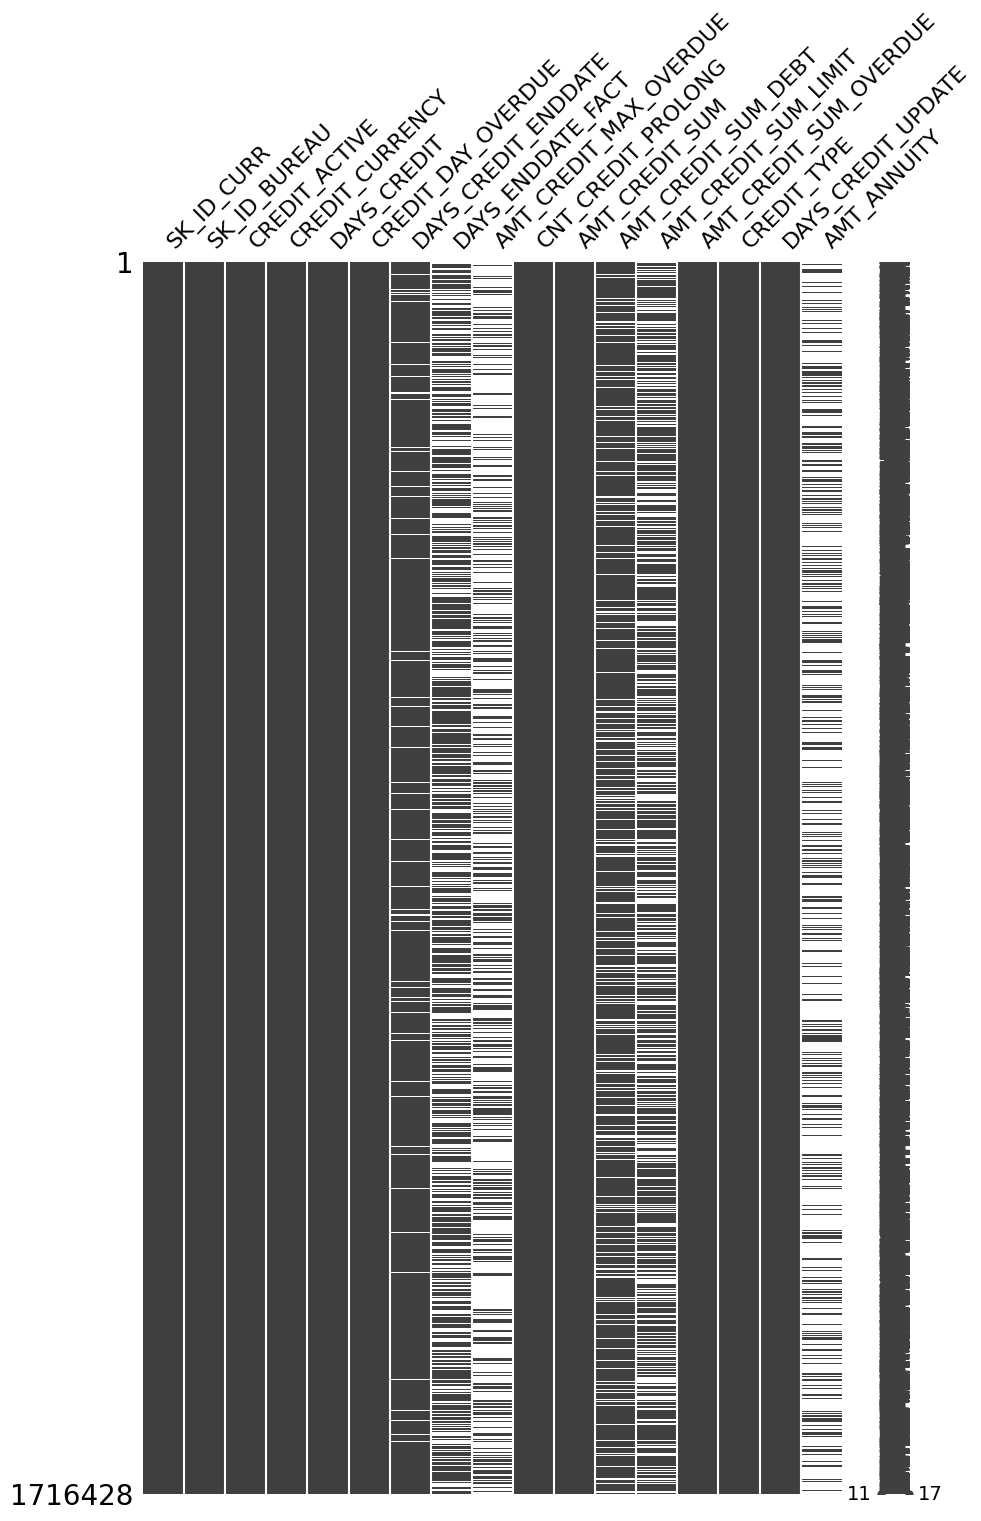

In [27]:
msno.matrix(df_bureau, figsize=(10,16))

## bureau_balance

In [ ]:
"""
Soldes mensuels des crédits antérieurs dans Credit Bureau.

une ligne pour chaque mois de l'historique de chaque crédit antérieur déclaré Credit Bureau
(# de prêts dans l'échantillon * # de crédits antérieurs relatifs * # de mois où nous avons un historique observable pour les crédits antérieurs) lignes.
"""

In [28]:
df_bureau_balance = pd.read_csv(DATA_BASE + "bureau_balance.csv")
df_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [29]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Valeurs possibles de status

In [30]:
df_bureau_balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

# Jointures

jointure application_train + bureau

In [23]:
df = pd.merge(df, df_bureau, on=['SK_ID_CURR'], how='left')
print("shape de application_train et bureau joints :", df.shape)
df.head()

shape de application_train et bureau joints : (1509345, 138)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158905.0,Closed,currency 

jointure application_train + bureau + bureau_balance

In [31]:
df = pd.merge(df, df_bureau_balance, on=['SK_ID_BUREAU'], how='left')
print("shape de application_train, bureau et bureau_balance joints :", df.shape)
df.head()

shape de application_train, bureau et bureau_balance joints : (15687442, 140)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,MONTHS_BALANCE,STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0,-15.0,C
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,